# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
farthest_point = manager.Value("s", "test")

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def coreset_sampling(aspect_model, sentiment_model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    farthest_data = farthest_point.value
    if farthest_data is not None:
        X_pool.append(farthest_data)
        
    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool,
        [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))

        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

        embeddings = np.array(list(aspect_outputs.values()))
        distance_matrix = pairwise_distances(embeddings)
        selected_indices = distance_matrix.shape[0] - 1 if farthest_data is not None else 0

        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point.value = aspect_dataset[sorted_dist[0]]['ori_text']

        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
            
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        end_time = time.time() 
        duration = end_time - start_time

        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
        
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = f'casa-coreset-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init Size {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed,
            filename
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            farthest_point,
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i,
            filename
        )
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed,
        filename
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

Init Size 1
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6716, Accuracy: 0.6763, F1 Micro: 0.7845, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.623, Accuracy: 0.724, F1 Micro: 0.8277, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5676, Accuracy: 0.7478, F1 Micro: 0.8485, F1 Macro: 0.8168
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5258, Accuracy: 0.776, F1 Micro: 0.8712, F1 Macro: 0.865
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4874, Accuracy: 0.7932, F1 Micro: 0.884, F1 Macro: 0.8824
Epoch 6/10, Train Loss: 0.453, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 7/10, Train Loss: 0.4214, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 8/10, Train Loss: 0.4196, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 9/10, Train Loss: 0.3868, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Epoch 10/10, Train Loss: 0.3569, Accuracy: 0.7917, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6232, Accuracy: 0.7778, F1 Micro: 0.7778, F1 Macro: 0.4375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4977, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3777, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2928, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2176, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1723, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6474, Accuracy: 0.7753, F1 Micro: 0.868, F1 Macro: 0.8567
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5756, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5198, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5086, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4882, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4734, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4326, Accuracy: 0.8013, F1 Micro: 0.8882, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4027, Accuracy: 0.817, F1 Micro: 0.8957, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6517, Accuracy: 0.7311, F1 Micro: 0.7311, F1 Macro: 0.451
Epoch 2/10, Train Loss: 0.7234, Accuracy: 0.7227, F1 Micro: 0.7227, F1 Macro: 0.4195
Epoch 3/10, Train Loss: 0.5622, Accuracy: 0.7227, F1 Micro: 0.7227, F1 Macro: 0.4195
Epoch 4/10, Train Loss: 0.6315, Accuracy: 0.7227, F1 Micro: 0.7227, F1 Macro: 0.4195
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5306, Accuracy: 0.7311, F1 Micro: 0.7311, F1 Macro: 0.451
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4792, Accuracy: 0.7647, F1 Micro: 0.7647, F1 Macro: 0.5793
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4261, Accuracy: 0.8403, F1 Micro: 0.8403, F1 Macro: 0.7906
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3865, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.8084
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2885, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.8165
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6144, Accuracy: 0.7932, F1 Micro: 0.884, F1 Macro: 0.8824
Epoch 2/10, Train Loss: 0.5587, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.5199, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4913, Accuracy: 0.8043, F1 Micro: 0.8896, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.455, Accuracy: 0.8311, F1 Micro: 0.9024, F1 Macro: 0.9009
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3763, Accuracy: 0.8676, F1 Micro: 0.9212, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3663, Accuracy: 0.8847, F1 Micro: 0.9294, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2883, Accuracy: 0.904, F1 Micro: 0.941, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2595, Accuracy: 0.9152, F1 Micro: 0.9478, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4883, Accuracy: 0.6955, F1 Micro: 0.6955, F1 Macro: 0.4102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4222, Accuracy: 0.6955, F1 Micro: 0.6955, F1 Macro: 0.4102
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3268, Accuracy: 0.7273, F1 Micro: 0.7273, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2102, Accuracy: 0.7682, F1 Micro: 0.7682, F1 Macro: 0.6628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2017, Accuracy: 0.8591, F1 Micro: 0.8591, F1 Macro: 0.8284
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.8591, F1 Micro: 0.8591, F1 Macro: 0.8394
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.8773, F1 Micro: 0.8773, F1 Macro: 0.8533
Epoch 8/10, Train Loss: 0.1004, Accuracy: 0.8727, F1 Micro: 0.8727, F1 Macro: 0.8471
Epoch 9/10, Train Loss: 0.0935, Accuracy: 0.8727, F1 Micro: 0.8727, F1 Macro: 0.8471
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5911, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5285, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4808, Accuracy: 0.8043, F1 Micro: 0.8895, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4461, Accuracy: 0.84, F1 Micro: 0.9063, F1 Macro: 0.9045
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3852, Accuracy: 0.8817, F1 Micro: 0.9276, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3138, Accuracy: 0.9018, F1 Micro: 0.9395, F1 Macro: 0.9365
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2648, Accuracy: 0.9182, F1 Micro: 0.9496, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2258, Accuracy: 0.9234, F1 Micro: 0.9522, F1 Macro: 0.9498
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5988, Accuracy: 0.6883, F1 Micro: 0.6883, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4304, Accuracy: 0.7449, F1 Micro: 0.7449, F1 Macro: 0.7167
Epoch 3/10, Train Loss: 0.3264, Accuracy: 0.7409, F1 Micro: 0.7409, F1 Macro: 0.7303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.8502, F1 Micro: 0.8502, F1 Macro: 0.8235
Epoch 5/10, Train Loss: 0.1608, Accuracy: 0.8462, F1 Micro: 0.8462, F1 Macro: 0.8354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1294, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.8722
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.8907, F1 Micro: 0.8907, F1 Macro: 0.8693
Epoch 9/10, Train Loss: 0.1188, Accuracy: 0.8704, F1 Micro: 0.8704, F1 Macro: 0.8588
Epoch 10/10, Train Loss: 0.0822, Accuracy: 0.8866, F1 Micro: 0.8866, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5871, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4946, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4658, Accuracy: 0.8229, F1 Micro: 0.8981, F1 Macro: 0.8966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3994, Accuracy: 0.8921, F1 Micro: 0.9352, F1 Macro: 0.9337
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3263, Accuracy: 0.9182, F1 Micro: 0.9494, F1 Macro: 0.9473
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2771, Accuracy: 0.9286, F1 Micro: 0.956, F1 Macro: 0.9541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2194, Accuracy: 0.939, F1 Micro: 0.962, F1 Macro: 0.96
Epoch 8/10, Train Loss: 0.1729, Accuracy: 0.9368, F1 Micro: 0.9601, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1487, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5662, Accuracy: 0.6902, F1 Micro: 0.6902, F1 Macro: 0.4084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3967, Accuracy: 0.7333, F1 Micro: 0.7333, F1 Macro: 0.6251
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2721, Accuracy: 0.8235, F1 Micro: 0.8235, F1 Macro: 0.8073
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.8779
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.7647, F1 Micro: 0.7647, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1622, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.872
Epoch 7/10, Train Loss: 0.1304, Accuracy: 0.8627, F1 Micro: 0.8627, F1 Macro: 0.8494
Epoch 8/10, Train Loss: 0.0783, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.8734
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.8784, F1 Micro: 0.8784, F1 Macro: 0.8644
Epoch 10/10, Train Loss: 0.064, Accuracy: 0.8863, F1 Micro: 0.8863, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5719, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4954, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4377, Accuracy: 0.8683, F1 Micro: 0.9224, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3415, Accuracy: 0.9167, F1 Micro: 0.9487, F1 Macro: 0.9465
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2698, Accuracy: 0.9301, F1 Micro: 0.9566, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2082, Accuracy: 0.9405, F1 Micro: 0.9629, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1646, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.969
Epoch 8/10, Train Loss: 0.1395, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9684
Epoch 9/10, Train Loss: 0.1132, Accuracy: 0.9442, F1 Micro: 0.9646, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5854, Accuracy: 0.6611, F1 Micro: 0.6611, F1 Macro: 0.4408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4197, Accuracy: 0.7741, F1 Micro: 0.7741, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8929
Epoch 4/10, Train Loss: 0.1039, Accuracy: 0.8954, F1 Micro: 0.8954, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9096
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9213
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.887, F1 Micro: 0.887, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9372, F1 Micro: 0.9372, F1 Macro: 0.9306
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9061
Epoch 10/10, Train Loss: 0.0483, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5632, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4774, Accuracy: 0.7999, F1 Micro: 0.8874, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4256, Accuracy: 0.8765, F1 Micro: 0.9268, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3308, Accuracy: 0.9167, F1 Micro: 0.9486, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2612, Accuracy: 0.9308, F1 Micro: 0.9568, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2025, Accuracy: 0.9397, F1 Micro: 0.9622, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1674, Accuracy: 0.9487, F1 Micro: 0.9677, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1384, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5478, Accuracy: 0.6776, F1 Micro: 0.6776, F1 Macro: 0.4039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3582, Accuracy: 0.8653, F1 Micro: 0.8653, F1 Macro: 0.8541
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.8286, F1 Micro: 0.8286, F1 Macro: 0.8202
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8979
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8877
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.8816, F1 Micro: 0.8816, F1 Macro: 0.8718
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8816
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8998
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0738, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5526, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4806, Accuracy: 0.8311, F1 Micro: 0.9032, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3876, Accuracy: 0.9107, F1 Micro: 0.9451, F1 Macro: 0.9428
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2892, Accuracy: 0.9315, F1 Micro: 0.9576, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2129, Accuracy: 0.9442, F1 Micro: 0.9652, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1697, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9679
Epoch 7/10, Train Loss: 0.1276, Accuracy: 0.9487, F1 Micro: 0.9677, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1055, Accuracy: 0.9516, F1 Micro: 0.9695, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0861, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5626, Accuracy: 0.6929, F1 Micro: 0.6929, F1 Macro: 0.4317
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3671, Accuracy: 0.8539, F1 Micro: 0.8539, F1 Macro: 0.8432
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9108
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9108
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8691
Epoch 6/10, Train Loss: 0.1702, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.12, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1012, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9202
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5586, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4664, Accuracy: 0.8363, F1 Micro: 0.9059, F1 Macro: 0.9051
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3746, Accuracy: 0.9241, F1 Micro: 0.9529, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2679, Accuracy: 0.9375, F1 Micro: 0.961, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.218, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9675
Epoch 6/10, Train Loss: 0.1611, Accuracy: 0.9487, F1 Micro: 0.9677, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1253, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0854, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5301, Accuracy: 0.8196, F1 Micro: 0.8196, F1 Macro: 0.7736
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.311, Accuracy: 0.8824, F1 Micro: 0.8824, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9164
Epoch 4/10, Train Loss: 0.1443, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.8781
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9344
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9302
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9386
Epoch 10/10, Train Loss: 0.0807, Accuracy: 0.9059, F1 Micro: 0.9059, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5518, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.472, Accuracy: 0.8289, F1 Micro: 0.9021, F1 Macro: 0.9013
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3679, Accuracy: 0.9271, F1 Micro: 0.9549, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2574, Accuracy: 0.9375, F1 Micro: 0.961, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2038, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.9539, F1 Micro: 0.9708, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1163, Accuracy: 0.9606, F1 Micro: 0.975, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1031, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0839, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5861, Accuracy: 0.7196, F1 Micro: 0.7196, F1 Macro: 0.5479
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2839, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1683, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1258, Accuracy: 0.941, F1 Micro: 0.941, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9446, F1 Micro: 0.9446, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9458
Epoch 7/10, Train Loss: 0.0563, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.9038
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9446, F1 Micro: 0.9446, F1 Macro: 0.9374
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9224
Epoch 10/10, Train Loss: 0.0655, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.556, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4544, Accuracy: 0.8341, F1 Micro: 0.9048, F1 Macro: 0.9041
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3506, Accuracy: 0.9204, F1 Micro: 0.9509, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2566, Accuracy: 0.9457, F1 Micro: 0.9659, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1907, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1473, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1262, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0804, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5827, Accuracy: 0.7581, F1 Micro: 0.7581, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3121, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2207, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1463, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.941
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.9516, F1 Micro: 0.9516, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9556, F1 Micro: 0.9556, F1 Macro: 0.9501
Epoch 8/10, Train Loss: 0.1051, Accuracy: 0.9476, F1 Micro: 0.9476, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9556, F1 Micro: 0.9556, F1 Macro: 0.9503
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5408, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4608, Accuracy: 0.8542, F1 Micro: 0.9153, F1 Macro: 0.9147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3381, Accuracy: 0.9271, F1 Micro: 0.9546, F1 Macro: 0.952
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2471, Accuracy: 0.939, F1 Micro: 0.9619, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1804, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1458, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Macro: 0.9695
Epoch 7/10, Train Loss: 0.1131, Accuracy: 0.9554, F1 Micro: 0.9717, F1 Macro: 0.9698
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9554, F1 Micro: 0.9717, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5771, Accuracy: 0.8577, F1 Micro: 0.8577, F1 Macro: 0.8397
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2477, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9231
Epoch 4/10, Train Loss: 0.1301, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9317
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9245
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9377
Epoch 10/10, Train Loss: 0.0849, Accuracy: 0.9346, F1 Micro: 0.9346, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5427, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4524, Accuracy: 0.8757, F1 Micro: 0.9266, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3343, Accuracy: 0.939, F1 Micro: 0.9624, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2447, Accuracy: 0.9516, F1 Micro: 0.9701, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5596, Accuracy: 0.8577, F1 Micro: 0.8577, F1 Macro: 0.8307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2824, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2505, Accuracy: 0.9526, F1 Micro: 0.9526, F1 Macro: 0.9465
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.938
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.9376
Epoch 6/10, Train Loss: 0.0805, Accuracy: 0.9447, F1 Micro: 0.9447, F1 Macro: 0.938
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9253
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9419
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9291
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.9486, F1 Micro: 0.9486, F1 Macro: 0.9419

Sentiment analysis accuracy: 0.9526, F1 Micro: 0.952

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5413, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.425, Accuracy: 0.8973, F1 Micro: 0.9379, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3125, Accuracy: 0.936, F1 Micro: 0.9601, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2257, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1697, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0984, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9801
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Epoch 10/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5173, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9278
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9238
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9356
Epoch 7/10, Train Loss: 0.1087, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9176
Epoch 8/10, Train Loss: 0.1158, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9189
Epoch 9/10, Train Loss: 0.1022, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9217
Epoch 10/10, Train Loss: 0.0645, Accuracy: 0.9382, F1 Micro: 0.9382, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5458, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4264, Accuracy: 0.9085, F1 Micro: 0.9447, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2957, Accuracy: 0.9464, F1 Micro: 0.9669, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2065, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9771
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5006, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2262, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9236
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9338
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9152
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9229
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9433
Epoch 10/10, Train Loss: 0.0565, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5391, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4187, Accuracy: 0.9025, F1 Micro: 0.9394, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2812, Accuracy: 0.9501, F1 Micro: 0.9691, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1985, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2737, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.9014
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.917
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9353
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9364
Epoch 7/10, Train Loss: 0.117, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.9048
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9246
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9279
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5359, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4092, Accuracy: 0.9107, F1 Micro: 0.9457, F1 Macro: 0.9442
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2839, Accuracy: 0.9435, F1 Micro: 0.9648, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1975, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9806
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5093, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8915
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1994, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1548, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9404
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9394
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9394
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9315
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9241
Epoch 10/10, Train Loss: 0.0531, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.54, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.418, Accuracy: 0.9137, F1 Micro: 0.9464, F1 Macro: 0.9446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.279, Accuracy: 0.9494, F1 Micro: 0.9687, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9729
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9782
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5023, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2292, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9177
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1408, Accuracy: 0.9446, F1 Micro: 0.9446, F1 Macro: 0.9374
Epoch 4/10, Train Loss: 0.1164, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9263
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9238
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.941, F1 Micro: 0.941, F1 Macro: 0.9338
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9461
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9109
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9299, F1 Micro: 0.9299, F1 Macro: 0.9203
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9186

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5334, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4044, Accuracy: 0.9278, F1 Micro: 0.9555, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2601, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9776
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9786
Higher F1 achieved, saving m

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5543, Accuracy: 0.8808, F1 Micro: 0.8808, F1 Macro: 0.8672
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2494, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9327
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9287
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9313
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9195
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9243
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9204
Epoch 10/10, Train Loss: 0.0585, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9167

Sentiment analysis accuracy: 0.9385, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5317, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4013, Accuracy: 0.9241, F1 Micro: 0.9532, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2649, Accuracy: 0.9479, F1 Micro: 0.9676, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1908, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9767
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 10/10, Train Loss: 0.0482, Accuracy: 0.9621, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5346, Accuracy: 0.8789, F1 Micro: 0.8789, F1 Macro: 0.8586
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9356
Epoch 3/10, Train Loss: 0.1665, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9171
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9203
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9233
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9198
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9315
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9129
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9274
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.93

Sentiment analysis accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9356
             

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.522, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.381, Accuracy: 0.9293, F1 Micro: 0.9564, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2526, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9781
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.968, F1 Micro: 0.9797, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5221, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9374
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1302, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9367
Epoch 4/10, Train Loss: 0.1257, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.9063
Epoch 5/10, Train Loss: 0.0947, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9251
Epoch 6/10, Train Loss: 0.0747, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9159
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9211
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9111
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9334
Epoch 10/10, Train Loss: 0.0549, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9234

Sentiment analysis accuracy: 0.9434, F1 Micro: 0.94

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3814, Accuracy: 0.9219, F1 Micro: 0.9513, F1 Macro: 0.9491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2343, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9795
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9802
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4915, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2207, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9316
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9253
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9401
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9216
Epoch 7/10, Train Loss: 0.0865, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.958, F1 Micro: 0.958, F1 Macro: 0.9528
Epoch 10/10, Train Loss: 0.0683, Accuracy: 0.9427, F1 Micro: 0.9427, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5337, Accuracy: 0.8021, F1 Micro: 0.8886, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3776, Accuracy: 0.9263, F1 Micro: 0.9542, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2411, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9765
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.512, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8799
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2338, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9284
Epoch 3/10, Train Loss: 0.1628, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9041
Epoch 4/10, Train Loss: 0.1346, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0995, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9358
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9321
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9483
Epoch 10/10, Train Loss: 0.0569, Accuracy: 0.9457, F1 Micro: 0.9457, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5274, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3687, Accuracy: 0.9323, F1 Micro: 0.9583, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2399, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9799
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9792
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4904, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2264, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9272
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9248
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9399
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9313
Epoch 8/10, Train Loss: 0.0757, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9248
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9129
Epoch 10/10, Train Loss: 0.0512, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9276

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5138, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3583, Accuracy: 0.9338, F1 Micro: 0.9589, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2311, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9776
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9768
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9807
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9785
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9772
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.9695, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5298, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2614, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9302
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9447
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9366
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9502, F1 Micro: 0.9502, F1 Macro: 0.9435
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9298
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9322
Epoch 10/10, Train Loss: 0.064, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Ma

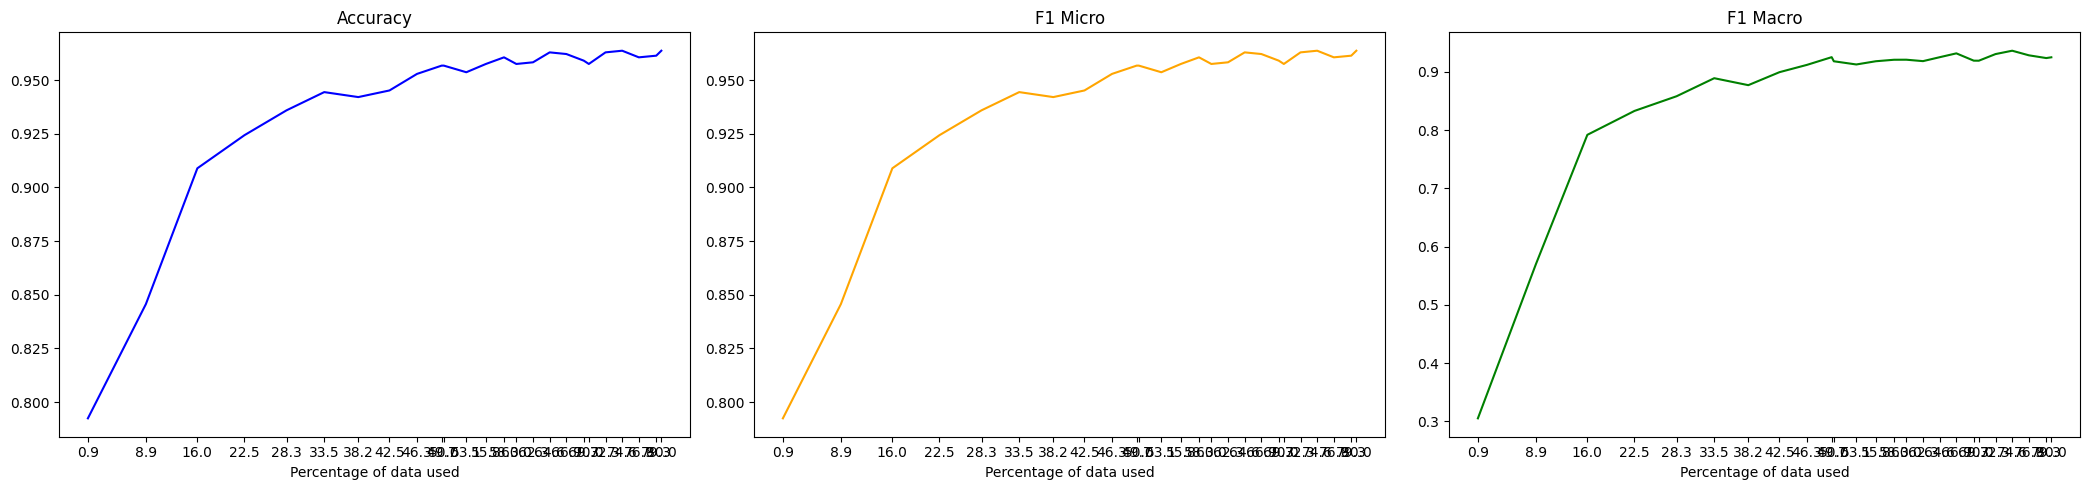

In [21]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 1)

Init Size 10
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6328, Accuracy: 0.7493, F1 Micro: 0.85, F1 Macro: 0.8204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5334, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4951, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4625, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.4453, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4135, Accuracy: 0.7999, F1 Micro: 0.8872, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3939, Accuracy: 0.8177, F1 Micro: 0.8959, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3601, Accuracy: 0.846, F1 Micro: 0.91, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3088, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.4466
Epoch 2/10, Train Loss: 0.5679, Accuracy: 0.7374, F1 Micro: 0.7374, F1 Macro: 0.4244
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5035, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.4466
Epoch 4/10, Train Loss: 0.4771, Accuracy: 0.7318, F1 Micro: 0.7318, F1 Macro: 0.5318
Epoch 5/10, Train Loss: 0.4109, Accuracy: 0.7263, F1 Micro: 0.7263, F1 Macro: 0.622
Epoch 6/10, Train Loss: 0.3137, Accuracy: 0.7263, F1 Micro: 0.7263, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.267, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1947, Accuracy: 0.7821, F1 Micro: 0.7821, F1 Macro: 0.7454
Epoch 9/10, Train Loss: 0.1264, Accuracy: 0.7765, F1 Micro: 0.7765, F1 Macro: 0.7258
Epoch 10/10, Train Loss: 0.0975, Accuracy: 0.7542, F1 Micro: 0.7542, F1 Macro: 0.7018

Sentiment analysis accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5943, Accuracy: 0.7924, F1 Micro: 0.8834, F1 Macro: 0.8817
Epoch 2/10, Train Loss: 0.5018, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4723, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4252, Accuracy: 0.7939, F1 Micro: 0.8844, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4106, Accuracy: 0.8237, F1 Micro: 0.8986, F1 Macro: 0.8971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3591, Accuracy: 0.8638, F1 Micro: 0.9192, F1 Macro: 0.9178
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3141, Accuracy: 0.8921, F1 Micro: 0.9341, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2544, Accuracy: 0.904, F1 Micro: 0.9411, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2189, Accuracy: 0.9137, F1 Micro: 0.9469, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6831, Accuracy: 0.6828, F1 Micro: 0.6828, F1 Macro: 0.4188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6163, Accuracy: 0.7753, F1 Micro: 0.7753, F1 Macro: 0.7264
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5003, Accuracy: 0.8458, F1 Micro: 0.8458, F1 Macro: 0.8275
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3494, Accuracy: 0.8546, F1 Micro: 0.8546, F1 Macro: 0.8421
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2511, Accuracy: 0.8899, F1 Micro: 0.8899, F1 Macro: 0.8724
Epoch 6/10, Train Loss: 0.1681, Accuracy: 0.8767, F1 Micro: 0.8767, F1 Macro: 0.8649
Epoch 7/10, Train Loss: 0.1372, Accuracy: 0.8855, F1 Micro: 0.8855, F1 Macro: 0.8706
Epoch 8/10, Train Loss: 0.1488, Accuracy: 0.8414, F1 Micro: 0.8414, F1 Macro: 0.8299
Epoch 9/10, Train Loss: 0.1512, Accuracy: 0.8767, F1 Micro: 0.8767, F1 Macro: 0.8615
Epoch 10/10, Train Loss: 0.1699, Accuracy: 0.8767, F1 Micro: 0.8767, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.59, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5177, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.7909, F1 Micro: 0.8826, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4423, Accuracy: 0.8259, F1 Micro: 0.8991, F1 Macro: 0.8977
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3697, Accuracy: 0.881, F1 Micro: 0.9283, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3162, Accuracy: 0.9107, F1 Micro: 0.9448, F1 Macro: 0.9423
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2728, Accuracy: 0.9219, F1 Micro: 0.9514, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2267, Accuracy: 0.933, F1 Micro: 0.9584, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5824, Accuracy: 0.6805, F1 Micro: 0.6805, F1 Macro: 0.4049
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4405, Accuracy: 0.7842, F1 Micro: 0.7842, F1 Macro: 0.7261
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2871, Accuracy: 0.8382, F1 Micro: 0.8382, F1 Macro: 0.8251
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1424, Accuracy: 0.8755, F1 Micro: 0.8755, F1 Macro: 0.8629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.8797, F1 Micro: 0.8797, F1 Macro: 0.8602
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8995
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.8791
Epoch 9/10, Train Loss: 0.0906, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8725
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5736, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5117, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4559, Accuracy: 0.8222, F1 Micro: 0.8983, F1 Macro: 0.8969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3884, Accuracy: 0.8958, F1 Micro: 0.9361, F1 Macro: 0.9342
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3203, Accuracy: 0.9144, F1 Micro: 0.947, F1 Macro: 0.9441
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.255, Accuracy: 0.9338, F1 Micro: 0.9587, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1937, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.9642
Epoch 8/10, Train Loss: 0.1686, Accuracy: 0.9412, F1 Micro: 0.963, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1358, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6183, Accuracy: 0.7143, F1 Micro: 0.7143, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4262, Accuracy: 0.8653, F1 Micro: 0.8653, F1 Macro: 0.8561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2376, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.9041
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1709, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1514, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9194
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8992
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1235, Accuracy: 0.9265, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5718, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5132, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4436, Accuracy: 0.8698, F1 Micro: 0.9227, F1 Macro: 0.9217
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3378, Accuracy: 0.9256, F1 Micro: 0.9539, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2635, Accuracy: 0.936, F1 Micro: 0.9602, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2107, Accuracy: 0.9487, F1 Micro: 0.9679, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1628, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1383, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9714
Epoch 9/10, Train Loss: 0.1116, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5876, Accuracy: 0.6844, F1 Micro: 0.6844, F1 Macro: 0.4063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4026, Accuracy: 0.8555, F1 Micro: 0.8555, F1 Macro: 0.8442
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.8859, F1 Micro: 0.8859, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.8859, F1 Micro: 0.8859, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1425, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9263
Epoch 7/10, Train Loss: 0.1546, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9358
Epoch 9/10, Train Loss: 0.0963, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9272
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5583, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4858, Accuracy: 0.808, F1 Micro: 0.8915, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3962, Accuracy: 0.907, F1 Micro: 0.9433, F1 Macro: 0.9418
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2984, Accuracy: 0.936, F1 Micro: 0.9604, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2321, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1805, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Epoch 7/10, Train Loss: 0.1346, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9524, F1 Micro: 0.9698, F1 Macro: 0.9666
Epoch 9/10, Train Loss: 0.0963, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9714
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5809, Accuracy: 0.7244, F1 Micro: 0.7244, F1 Macro: 0.5884
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3842, Accuracy: 0.8858, F1 Micro: 0.8858, F1 Macro: 0.8761
Epoch 3/10, Train Loss: 0.2378, Accuracy: 0.8307, F1 Micro: 0.8307, F1 Macro: 0.8242
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1952, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9339
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9417
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9528, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5623, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4916, Accuracy: 0.8132, F1 Micro: 0.8942, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3815, Accuracy: 0.9152, F1 Micro: 0.9474, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2878, Accuracy: 0.9338, F1 Micro: 0.9587, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2174, Accuracy: 0.9442, F1 Micro: 0.965, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1708, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1351, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.1108, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9732
Epoch 9/10, Train Loss: 0.0896, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.596, Accuracy: 0.6747, F1 Micro: 0.6747, F1 Macro: 0.4029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3635, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9317, F1 Micro: 0.9317, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.932
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.932
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9364
Epoch 9/10, Train Loss: 0.095, Accuracy: 0.9157, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5527, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4708, Accuracy: 0.8177, F1 Micro: 0.8965, F1 Macro: 0.8953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3652, Accuracy: 0.9189, F1 Micro: 0.9502, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2732, Accuracy: 0.9427, F1 Micro: 0.9643, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2044, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9672
Epoch 6/10, Train Loss: 0.1606, Accuracy: 0.9464, F1 Micro: 0.9664, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1308, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9722
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.9568, F1 Micro: 0.9728, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5755, Accuracy: 0.7472, F1 Micro: 0.7472, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3089, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.9019
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.9091
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1564, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9209
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1073, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9324
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9368, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5558, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4715, Accuracy: 0.8497, F1 Micro: 0.9128, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3517, Accuracy: 0.9293, F1 Micro: 0.9565, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2612, Accuracy: 0.9449, F1 Micro: 0.9656, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1999, Accuracy: 0.9472, F1 Micro: 0.9668, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1476, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1227, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1014, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0815, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5606, Accuracy: 0.8397, F1 Micro: 0.8397, F1 Macro: 0.8124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9144
Epoch 4/10, Train Loss: 0.1443, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8983
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9303
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9234
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9357
Epoch 10/10, Train Loss: 0.0738, Accuracy: 0.9389, F1 Micro: 0.9389, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5479, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4511, Accuracy: 0.8482, F1 Micro: 0.9121, F1 Macro: 0.911
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3441, Accuracy: 0.9278, F1 Micro: 0.9553, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2385, Accuracy: 0.942, F1 Micro: 0.9637, F1 Macro: 0.9616
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1876, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1459, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.118, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5518, Accuracy: 0.8289, F1 Micro: 0.8289, F1 Macro: 0.8062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.274, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1642, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9443
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.902
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9409
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9468, F1 Micro: 0.9468, F1 Macro: 0.9409
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.9582, F1 Micro: 0.9582, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5385, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4468, Accuracy: 0.8854, F1 Micro: 0.9308, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3211, Accuracy: 0.9278, F1 Micro: 0.9549, F1 Macro: 0.9517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2243, Accuracy: 0.9516, F1 Micro: 0.97, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1763, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1117, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5468, Accuracy: 0.8638, F1 Micro: 0.8638, F1 Macro: 0.8371
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2374, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2297, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9121
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9443
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.965, F1 Micro: 0.965, F1 Macro: 0.9612
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9369
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9572, F1 Micro: 0.9572, F1 Macro: 0.9526
Epoch 9/10, Train Loss: 0.0857, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9284
Epoch 10/10, Train Loss: 0.0713, Accuracy: 0.9572, F1 Micro: 0.9572, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5399, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4312, Accuracy: 0.8884, F1 Micro: 0.9329, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3061, Accuracy: 0.9338, F1 Micro: 0.9588, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2168, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9776
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5424, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.246, Accuracy: 0.9572, F1 Micro: 0.9572, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1773, Accuracy: 0.965, F1 Micro: 0.965, F1 Macro: 0.961
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9141
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.965, F1 Micro: 0.965, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.965, F1 Micro: 0.965, F1 Macro: 0.961
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9611, F1 Micro: 0.9611, F1 Macro: 0.957
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9473
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9572, F1 Micro: 0.9572, F1 Macro: 0.9526
Epoch 10/10, Train Loss: 0.0791, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5371, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4225, Accuracy: 0.9048, F1 Micro: 0.942, F1 Macro: 0.9403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2938, Accuracy: 0.942, F1 Micro: 0.9639, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2145, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9554, F1 Micro: 0.9717, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5504, Accuracy: 0.8661, F1 Micro: 0.8661, F1 Macro: 0.8577
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1347, Accuracy: 0.9567, F1 Micro: 0.9567, F1 Macro: 0.9506
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9685, F1 Micro: 0.9685, F1 Macro: 0.9646
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9646, F1 Micro: 0.9646, F1 Macro: 0.9603
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9456
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9646, F1 Micro: 0.9646, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0612, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5451, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.403, Accuracy: 0.9107, F1 Micro: 0.9448, F1 Macro: 0.9431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2839, Accuracy: 0.9472, F1 Micro: 0.9671, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1924, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9754
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9747
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5116, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2752, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1597, Accuracy: 0.9583, F1 Micro: 0.9583, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9583, F1 Micro: 0.9583, F1 Macro: 0.9533
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9438
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9583, F1 Micro: 0.9583, F1 Macro: 0.9535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9621, F1 Micro: 0.9621, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9621, F1 Micro: 0.9621, F1 Macro: 0.9574
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9413
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.536, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.422, Accuracy: 0.9152, F1 Micro: 0.9482, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.285, Accuracy: 0.933, F1 Micro: 0.9583, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2036, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1527, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9758
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9773
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9741
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4967, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2726, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9364
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9211
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9357
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.958, F1 Micro: 0.958, F1 Macro: 0.9531
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.937
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9504, F1 Micro: 0.9504, F1 Macro: 0.9451
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.958, F1 Micro: 0.958, F1 Macro: 0.9528
Epoch 10/10, Train Loss: 0.049, Accuracy: 0.9542, F1 Micro: 0.9542, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5317, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4069, Accuracy: 0.9189, F1 Micro: 0.9495, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2735, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1974, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9789
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9731
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9752
Epoch 10/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5117, Accuracy: 0.892, F1 Micro: 0.892, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1074, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9468
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9422
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.96, F1 Micro: 0.96, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.96, F1 Micro: 0.96, F1 Macro: 0.9559
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8981
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5279, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4004, Accuracy: 0.9226, F1 Micro: 0.9523, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2627, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1844, Accuracy: 0.9643, F1 Micro: 0.9778, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9688, F1 Micro: 0.9805, F1 Macro: 0.9795
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9734
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0714, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9702, F1 Micro: 0.9811, F1 Macro: 0.9795
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5217, Accuracy: 0.8858, F1 Micro: 0.8858, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2626, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9478
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9335
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9331
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9388
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9304
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9439
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9293
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9395
Epoch 10/10, Train Loss: 0.0459, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9304

Sentiment analysis accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9478
              prec

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5247, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4005, Accuracy: 0.9234, F1 Micro: 0.9524, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2522, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.188, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9762
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9591, F1 Micro: 0.974, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9783
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5025, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.9011
Epoch 2/10, Train Loss: 0.2293, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1611, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1501, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9411
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9287
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9547, F1 Micro: 0.9547, F1 Macro: 0.9487
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9455
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9411
Epoch 10/10, Train Loss: 0.0602, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9215

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3767, Accuracy: 0.9249, F1 Micro: 0.953, F1 Macro: 0.9506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2622, Accuracy: 0.9487, F1 Micro: 0.9679, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9799
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9776
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9782
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8772
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9432
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9344
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1074, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9468
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9264
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9426
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9302
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9341
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9178
Epoch 10/10, Train Loss: 0.0682, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9389

Sentiment analysis accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9468
    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5135, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3737, Accuracy: 0.9286, F1 Micro: 0.9557, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2424, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9773
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9762
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.9717, F1 Micro: 0.9823, F1 Macro: 0.9813
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9621, F1 Micro: 0.9759, F1 Macro: 0.9742
Epoch 10/10, Train Loss: 0.0453, Accuracy: 0.9702, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5339, Accuracy: 0.8902, F1 Micro: 0.8902, F1 Macro: 0.8785
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9399
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9351
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9302
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9276
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9206
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9317
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9128
Epoch 10/10, Train Loss: 0.0375, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9302

Sentiment analysis accuracy: 0.9451, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3791, Accuracy: 0.9226, F1 Micro: 0.9515, F1 Macro: 0.9483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2516, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.979
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9758
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5174, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.241, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9547, F1 Micro: 0.9547, F1 Macro: 0.9492
Epoch 4/10, Train Loss: 0.1236, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1079, Accuracy: 0.9547, F1 Micro: 0.9547, F1 Macro: 0.949
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9449
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9585, F1 Micro: 0.9585, F1 Macro: 0.9536
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9547, F1 Micro: 0.9547, F1 Macro: 0.9492
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9275
Epoch 10/10, Train Loss: 0.0485, Accuracy: 0.9358, F1 Micro: 0.9358, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5142, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3655, Accuracy: 0.936, F1 Micro: 0.9605, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2359, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9776
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4779, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8976
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.8727, F1 Micro: 0.8727, F1 Macro: 0.8646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9254
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.925
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.937
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.9588, F1 Micro: 0.9588, F1 Macro: 0.9524
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9246
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.9305
Epoch 10/10, Train Loss: 0.0447, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5177, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3675, Accuracy: 0.9301, F1 Micro: 0.9564, F1 Macro: 0.9539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2339, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macro: 0.9817
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9628, F1 Micro: 0.9764, F1 Macro: 0.9742
Epoch 10/10, Train Loss: 0.0438, Accuracy: 0.9673, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4811, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.9005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Epoch 3/10, Train Loss: 0.1445, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9146
Epoch 4/10, Train Loss: 0.1328, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9127
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9088
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9191
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.928
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9243
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.9048

Sentiment analysis accuracy: 0.9346, F1 Micro: 0.93

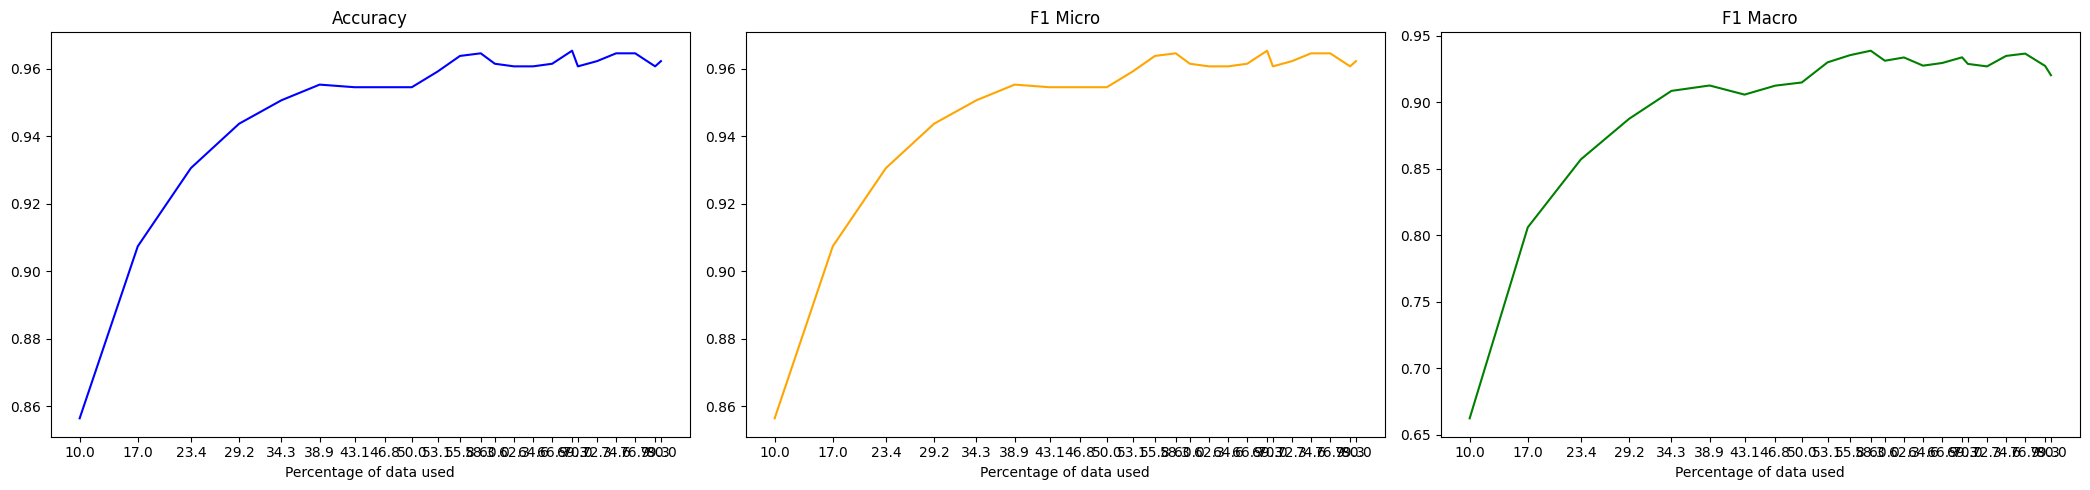

In [22]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 10)